### Analyzing data from the production database
We will plot Moving Averages on the hourly data and visualize the charts on plots using matplotlib and pandas
We will also create buy/sell signals in the charts using small red and green indicators.

> NOTE: This is for visualization, a DAG is available to run daily as a script for analysis.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()
TEST_DB_URL = os.getenv("TEST_DB_URL") # NOTE: This is the prod Postgres DB,not dev

In [3]:
# Read from SQL Table
prod_engine = create_engine(TEST_DB_URL)
new_df = pd.read_sql_table(table_name='hourly_crypto_data',con=prod_engine, schema='crypto')
new_df

,time,name,current_price,market_cap,total_volume
0,2025-06-03 17:49:50.216000+00:00,Cardano,0.690374,24918893558,483811113
1,2025-06-03 17:49:50.411000+00:00,Polkadot,4.190000,6380736313,179064300
2,2025-06-03 17:49:56.862000+00:00,Chainlink,14.360000,9444862637,381649190
3,2025-06-03 17:49:49.987000+00:00,Litecoin,90.070000,6837159694,300972703
4,2025-06-03 17:49:52.878000+00:00,Uniswap,6.700000,4023109009,486617180
...,...,...,...,...,...
274,2025-06-04 11:59:56.540000+00:00,Uniswap,6.790000,4073167715,478975656
275,2025-06-04 11:59:53.628000+00:00,Stellar,0.273195,8518354417,172879827
276,2025-06-04 11:59:56.004000+00:00,Aptos,4.920000,3107990127,120385362
277,2025-06-04 12:00:02.141000+00:00,XRP,2.250000,132392600144,2092404223


In [4]:
new_df['time'] = pd.to_datetime(new_df['time'], utc=True)
new_df.set_index('time', inplace=True)
new_df['name']

time
2025-06-03 17:49:50.216000+00:00      Cardano
2025-06-03 17:49:50.411000+00:00     Polkadot
2025-06-03 17:49:56.862000+00:00    Chainlink
2025-06-03 17:49:49.987000+00:00     Litecoin
2025-06-03 17:49:52.878000+00:00      Uniswap
                                      ...    
2025-06-04 11:59:56.540000+00:00      Uniswap
2025-06-04 11:59:53.628000+00:00      Stellar
2025-06-04 11:59:56.004000+00:00        Aptos
2025-06-04 12:00:02.141000+00:00          XRP
2025-06-04 12:00:03.090000+00:00    Avalanche
Name: name, Length: 279, dtype: object

In [6]:
names = new_df['name'].unique() # get the unique names per coin
names

array(['Cardano', 'Polkadot', 'Chainlink', 'Litecoin', 'Uniswap',
       'Stellar', 'Aptos', 'XRP', 'Avalanche'], dtype=object)

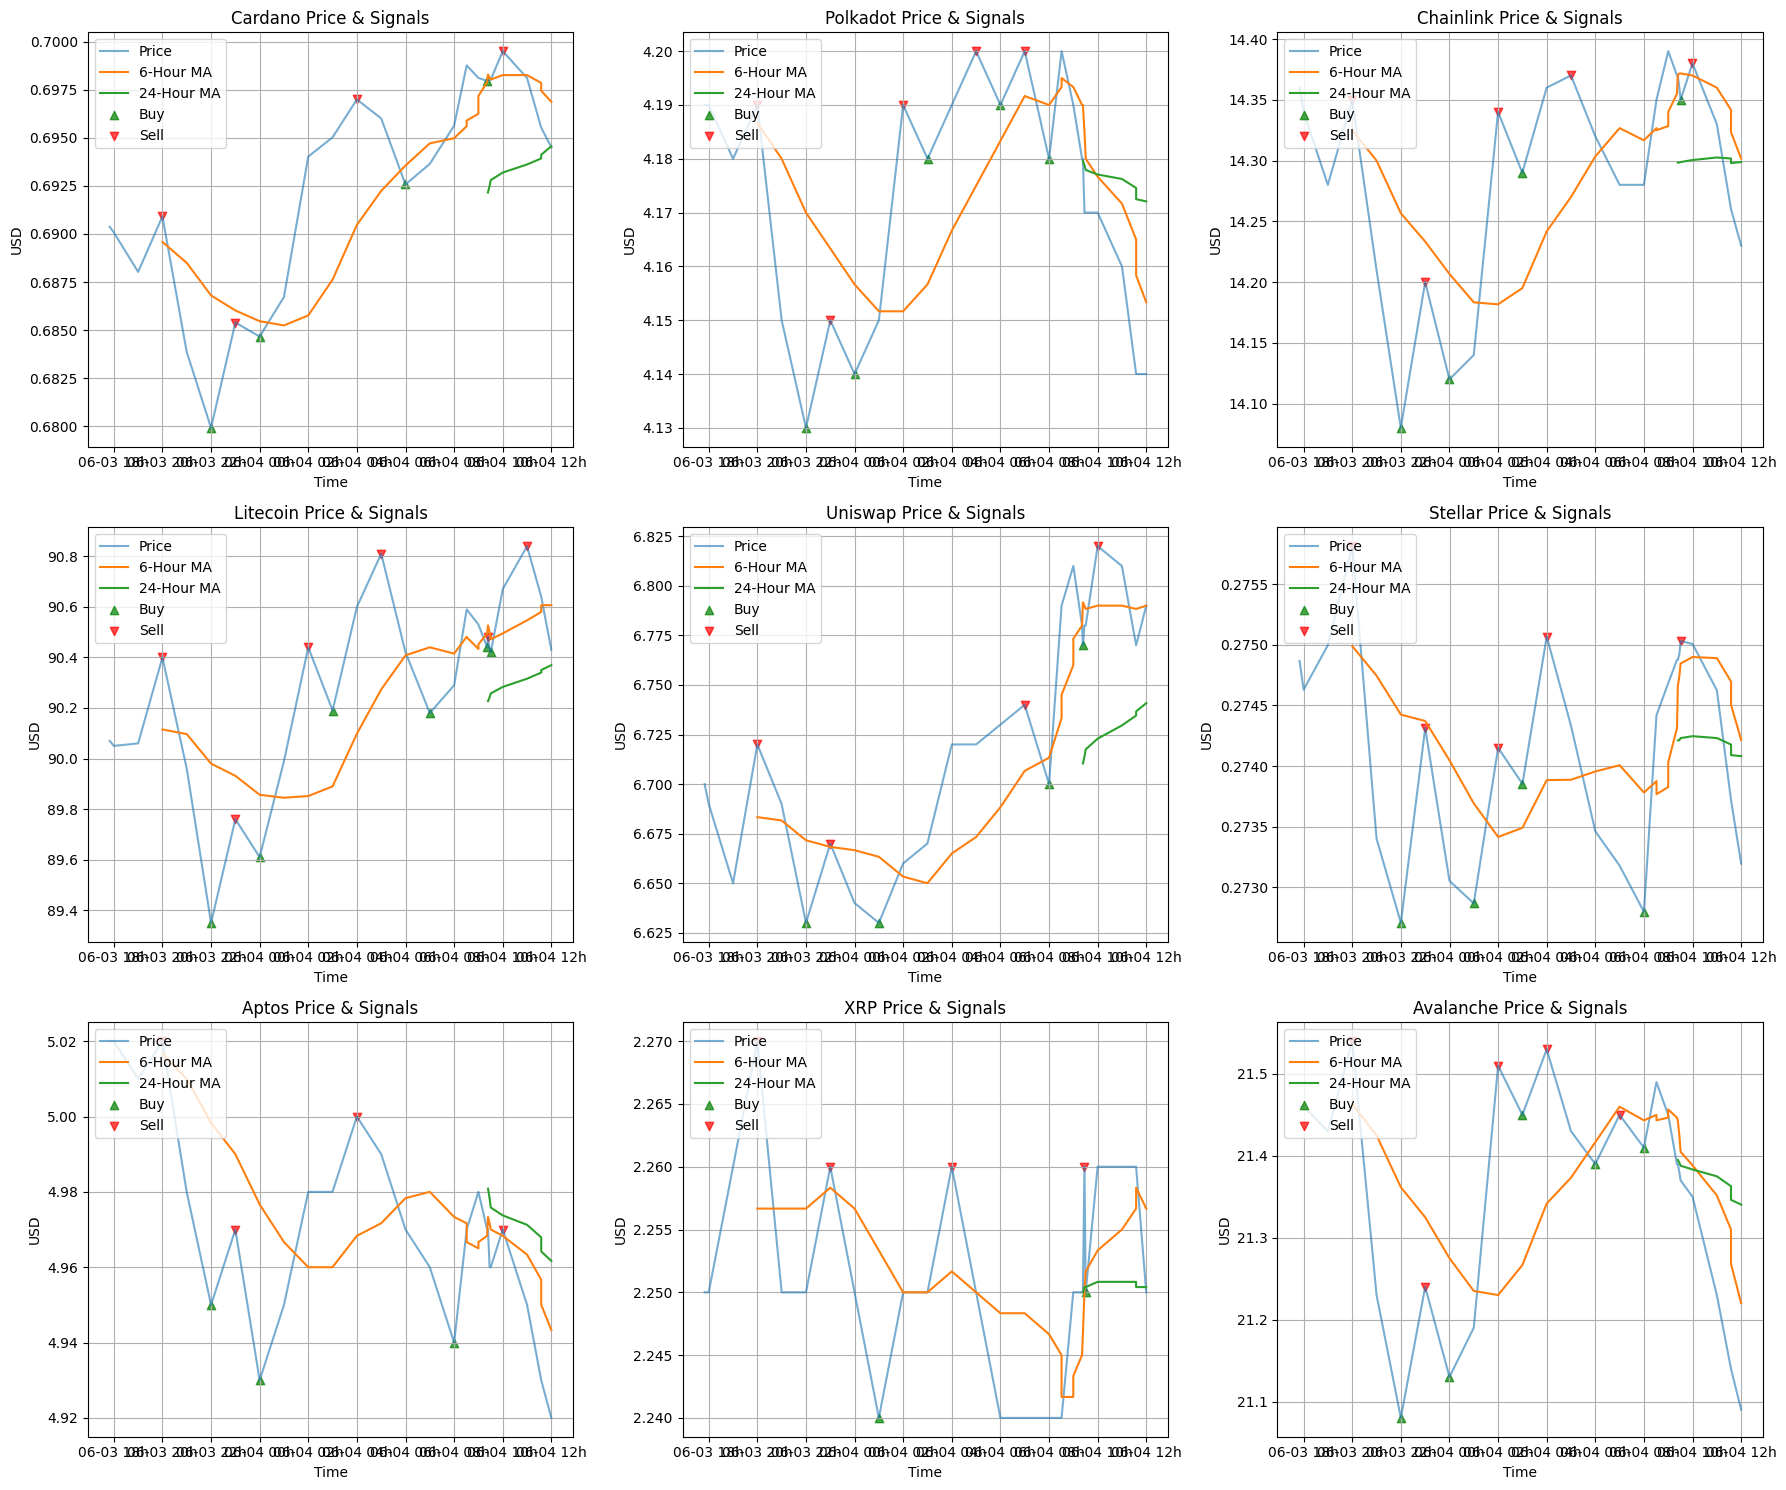

In [ ]:
rows = (len(names) + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows), sharex=False)
axes = axes.flatten()

for i, name in enumerate(names):
    coin_df = new_df[new_df['name'] == name].copy()

    # calculate moving averages and maxima and minima
    coin_df['MA_6'] = coin_df['current_price'].rolling(window=6).mean()
    coin_df['MA_24'] = coin_df['current_price'].rolling(window=24).mean()

    coin_df['min'] = coin_df['current_price'][(coin_df['current_price'].shift(1) > coin_df['current_price']) & (coin_df['current_price'].shift(-1) > coin_df['current_price'])]
    coin_df['max'] = coin_df['current_price'][(coin_df['current_price'].shift(1) < coin_df['current_price']) & (coin_df['current_price'].shift(-1) < coin_df['current_price'])]

    ax = axes[i]
    ax.plot(coin_df.index, coin_df['current_price'], label='Price', alpha=0.6)
    ax.plot(coin_df.index, coin_df['MA_6'], label='6-Hour MA')
    ax.plot(coin_df.index, coin_df['MA_24'], label='24-Hour MA')
    ax.scatter(coin_df.index, coin_df['min'], color='green', label='Buy', marker='^', alpha=0.7)
    ax.scatter(coin_df.index, coin_df['max'], color='red', label='Sell', marker='v', alpha=0.7)

    ax.set_title(f'{name} Analysis Chart')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %Hh'))
    ax.legend(loc='upper left')

# remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()